# Assignment 2a
## Numerical Optimization & Large Scale Linear Algebra
### Professor: P. Vassalos

### Stratos Gounidellis, DS3517005

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from scipy import linalg
from scipy.linalg import norm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib as mpl
import time
% matplotlib inline


## Data loading & Initial pre-processing

In [2]:
# read training and test data from excel file
xl = pd.ExcelFile("data_handwritten.xlsx")

# convert data to numpy array and transpose data
# in order to handle them in a morde convenient
# way
x_train = np.asarray(xl.parse("azip", header=None)).T
y_train = np.asarray(xl.parse("dzip", header=None)).T

x_test = np.asarray(xl.parse("testzip", header=None)).T
y_test = np.asarray(xl.parse("dtest", header=None)).T


In [3]:
# although data seem normalized, normalize them
# between -1 and 1 before applying SVD in order
# to avoid any problems
normalizer = MinMaxScaler(feature_range=(-1.0, 1.0))
X_train = normalizer.fit_transform(x_train)
X_test = normalizer.transform(x_test)


## Methods' declaration

In [4]:
# create a dictionary having as keys the
# the digits from 0 to 9 and as values all
# the training data corresponding to that specific
# key. That data separation is a necessary step for
# the implementation of the classification algorithm
# and its variations.
def create_dict(X, y):
    dict_digits = {}
    for i, digit in enumerate(list(y)):
        digit = int(digit)
        if digit in dict_digits.keys():
            dict_digits[digit].append(X[i])
        else:
            dict_digits[digit] = [X[i]]
    return dict_digits


In [18]:
# method to compute the k singular vectors
# of the training data
def svd_tranform(components, X_train):
    U_train, s_train, Vh_train = linalg.svd(np.asarray(X_train).T,
                                            check_finite=False)
    return U_train[:, 0:components], s_train[0:components]

# method to compute truncated SVD per digit.
# Return a dictionary containing different number
# of basis vectors (1-20) for each digit.
def trunc_svd(dict_train):
    svd_dict = {}
    for component in range(1, 21):
        temp = {}
        for digit in sorted(dict_train.keys()):
            temp[digit] = svd_tranform(component, dict_train[digit])[0]
        svd_dict[component] = temp
    return svd_dict


In [6]:
# method to convert an array to image,
# plot the first 21 digits from
# each class
def to_image(digit, dict_train):
    counter = 0
    while counter < 21:

        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(6, 6), ncols=3)
        array = dict_train[digit][counter].reshape(16, 16)
        array = (array - min(array.ravel())) * np.ones(array.shape)
        array = (20 / max(array.ravel())) * array

        ax1.imshow(np.uint8(array.reshape(16, 16)), cmap="gray")

        counter += 1
        array = dict_train[digit][counter].reshape(16, 16)
        array = (array - min(array.ravel()))*np.ones(array.shape)
        array = (20/max(array.ravel()))*array

        ax2.imshow(np.uint8(array.reshape(16, 16)), cmap="gray")

        counter += 1
        array = dict_train[digit][counter].reshape(16, 16)
        array = (array - min(array.ravel())) * np.ones(array.shape)
        array = (20 / max(array.ravel())) * array

        ax3.imshow(np.uint8(array.reshape(16, 16)), cmap="gray")


### Classifier - Question 1 & 2

In [7]:
def svd_classifier(x_test, components, svd_dict):
    # create a 2-D array with ones on the diagonal
    # and zeros elsewhere
    ones = np.eye(256)
    # initialize a list for the predictions
    y_pred = []
    for sample in x_test:
        # initialize a list for the norms
        norms = []
        for digit in svd_dict[components].keys():
            svd = svd_dict[components][digit]
            # compute 10 least squares residuals
            norms.append(norm(np.dot(ones - np.dot(svd, svd.T),
                                     sample)) / norm(sample))
        # ff one residual is significantly smaller than all
        # the others, classify as that.
        y_pred.append(norms.index(min(norms)))
    # return the prediction
    return y_pred


### Classifier - Question 3

In [29]:
def svd_classifier_adj(x_test, components, svd_dict, dig_component):
    ones = np.eye(256)
    y_pred = []
    for sample in x_test:
        norms = []
        for digit in svd_dict[components].keys():
            # since for digits 0, 1 and 6 greater accuracy and
            # F1-score can relative easy be achieved use a different
            # number of basis vectors (smaller). And apply the same
            # proceedure.
            if digit == 1:
                svd = svd_dict[dig_component][digit]
                norms.append(norm(np.dot(ones - np.dot(svd, svd.T),
                                         sample))/norm(sample))
            else:
                svd = svd_dict[components][digit]
                norms.append(norm(np.dot(ones - np.dot(svd, svd.T),
                                         sample))/norm(sample))
        y_pred.append(norms.index(min(norms)))
    return y_pred


### Classifier - Optional Question 1

In [9]:
def svd_classifier_adj2(x_test, components, svd_dict):
    ones = np.eye(256)
    y_pred = []
    counter = 0
    digits_pass = {el: 0 for el in list(svd_dict[components].keys())}
    for sample in x_test:
        norms = []
        for digit in svd_dict[components].keys():
            svd = svd_dict[components][digit]
            # compare the unknown digit only to the first singular vector in each class
            norms.append(norm(np.dot(ones - np.dot(svd[:, 0:1], svd[:, 0:1].T),
                                     sample))/norm(sample))
        # If for one class the residual is significantly smaller
        # than for the others, classify as that class.
        if norm(sorted(norms)[1] - sorted(norms)[0]) > 0.1:
            pred = norms.index(min(norms))
            y_pred.append(norms.index(min(norms)))
            counter += 1
            digits_pass[pred] += 1
            continue
        norms = []
        for digit in svd_dict[components].keys():
            svd = svd_dict[components][digit]
            norms.append(norm(np.dot(ones - np.dot(svd, svd.T),
                                     sample))/norm(sample))
        y_pred.append(norms.index(min(norms)))
    print("The second stage is unnecessary", counter, "times.")
    print(digits_pass)
    return y_pred


## Question 1

In [56]:
# initialize variables for the classification task
dict_train = create_dict(X_train, y_train)
svd_dict = trunc_svd(dict_train)


The following block of code runs the SVD classification algoirthm for a number of basis vectors in the range (5,20). Different metrics are used to evaluate the different approaches i.e. accuracy, recall, precision and F1-score.

<b>Accuracy</b> is the number of correct predictions made divided by the total number of predictions made, multiplied by one hundred (100) to turn it into a percentage. In order to calculate the total cost ratio mentioned below we also calculate error rate, which is one minus Accuracy.

<b>Precision</b> is the number of True Positives divided by the number of True Positives and False Positives. Precision can be considered a measure of a classifier’s exactness. A low precision can also indicate a large number of False Positives.

<b>Recall</b> is the number of True Positives divided by the number of True Positives and the number of False Negatives. In other way, it is the number of positive predictions divided by the number of positive class values in the test data. It is also known as Sensitivity or the True Positive Rate. Recall is a measure of a classifiers completeness. A low recall indicates many False  egatives.

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

<b>F1-score</b> is the 2 * ((precision * recall) / (precision + recall)). In other words, the F1-score conveys the balance between the precision and the recall.

In [58]:
accuracy_test = []
accuracy_train = []
vectors = np.arange(5, 21, 1)

# Use the first few (5-20) singular vectors as basis and
# classify unknown test digits according to how well
# they can be represented in terms of the respective bases.
# Calculate accuracy, precision, recall and f1-score for
# the different number of basis vectors.
for i in range(5, 21):
    y_pred_train = svd_classifier(X_train, i, svd_dict)
    y_pred_test = svd_classifier(X_test, i, svd_dict)

    print ("Number of SVD basis vectors:", i)

    acc_train = accuracy_score(y_pred_train, y_train.ravel())
    acc_test = accuracy_score(y_pred_test, y_test.ravel())
    print("Accuracy: %0.6f" % (acc_test))

    precision = precision_score(y_pred_test, y_test.ravel(), average="macro")
    print ('Precision:', precision)

    recall = recall_score(y_pred_test, y_test.ravel(), average="macro")
    print ('Recall:', recall)

    f1score = f1_score(y_pred_test, y_test.ravel(), average="macro")
    print ('F1-score:', f1score)

    accuracy_test.append(acc_test)
    accuracy_train.append(acc_train)
    print()


Number of SVD basis vectors: 5
Accuracy: 0.902342
Precision: 0.891782985528
Recall: 0.895423528187
F1-score: 0.892877972466

Number of SVD basis vectors: 6
Accuracy: 0.905331
Precision: 0.895055429928
Recall: 0.898731444668
F1-score: 0.896204935929

Number of SVD basis vectors: 7
Accuracy: 0.916791
Precision: 0.90701543579
Recall: 0.911837725095
F1-score: 0.908945281242

Number of SVD basis vectors: 8
Accuracy: 0.920279
Precision: 0.910803853313
Recall: 0.916317680559
F1-score: 0.913088773633

Number of SVD basis vectors: 9
Accuracy: 0.927255
Precision: 0.917802052084
Recall: 0.923900326546
F1-score: 0.920476481327

Number of SVD basis vectors: 10
Accuracy: 0.931739
Precision: 0.923053081208
Recall: 0.928232565664
F1-score: 0.925336710235

Number of SVD basis vectors: 11
Accuracy: 0.931739
Precision: 0.92307306617
Recall: 0.928736685408
F1-score: 0.925578478876

Number of SVD basis vectors: 12
Accuracy: 0.936721
Precision: 0.928785012689
Recall: 0.934109157088
F1-score: 0.931177091097


---Maximum Accuracy---
Number of Basis Vectors: 20, Accuracy: 0.99589923843


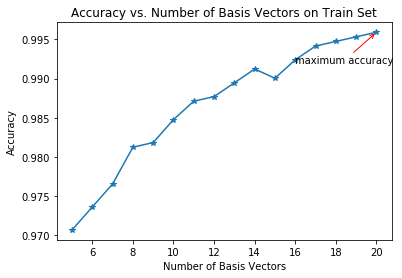

In [263]:
# plot the percentage of correctly classified digits
# as a function of the number of basis vectors for the
# training set.

fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel('Number of Basis Vectors')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Number of Basis Vectors on Train Set")

ymax = max(accuracy_train)
xpos = accuracy_train.index(ymax)
xmax = vectors[xpos]
print("---Maximum Accuracy---")
print("Number of Basis Vectors: " + str(xmax) + ", Accuracy: " + str(ymax))
ax.annotate('maximum accuracy', xy=(xmax, ymax), xytext=(xmax-4, ymax-0.004),
            arrowprops=dict(color='red', arrowstyle="->"),
            )

plt.plot(vectors, accuracy_train, marker='*')
plt.show()


---Maximum Accuracy---
Number of Basis Vectors: 18, Accuracy: 0.942202291978


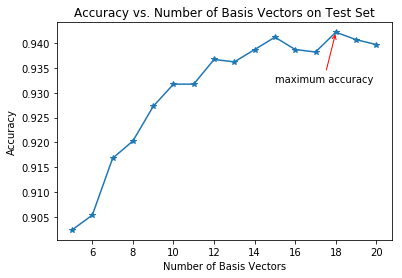

In [262]:
# plot the percentage of correctly classified digits
# as a function of the number of basis vectors for the
# test set. We observe maximum accuracy for 18 basis vectors.
# However, for 15 basis vectors we have almost the same 
# accuracy concequently could use 15 basis vectors in favor of
# parsimonious models.

fig = plt.figure()
ax = fig.add_subplot(111)

plt.xlabel('Number of Basis Vectors')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Number of Basis Vectors on Test Set")

ymax = max(accuracy_test)
xpos = accuracy_test.index(ymax)
xmax = vectors[xpos]
print("---Maximum Accuracy---")
print("Number of Basis Vectors: " + str(xmax) + ", Accuracy: " + str(ymax))
ax.annotate('maximum accuracy', xy=(xmax, ymax), xytext=(xmax-3, ymax-0.01),
            arrowprops=dict(color='red', arrowstyle="->"))

plt.plot(vectors, accuracy_test, marker='*')
plt.show()


## Question 2

In [58]:
# print the main classification metrics i.e.
# precision, recall and f1-score for each class
# We observe that it is easier to classify digits
# 0, 1 and 6 and more difficu,lt digits 5 and 3.
y_pred = svd_classifier(X_test, 15, svd_dict)
print("Classification report for %s:\n%s\n"
      % ("SVD basis classification algorithm",
         classification_report(y_test, y_pred)))


Classification report for SVD basis classification algorithm:
             precision    recall  f1-score   support

          0       0.94      0.99      0.96       359
          1       0.97      0.98      0.98       264
          2       0.95      0.90      0.93       198
          3       0.90      0.89      0.90       166
          4       0.92      0.93      0.93       200
          5       0.92      0.88      0.89       160
          6       0.98      0.95      0.96       170
          7       0.93      0.96      0.95       147
          8       0.96      0.92      0.94       166
          9       0.93      0.93      0.93       177

avg / total       0.94      0.94      0.94      2007




In [289]:
# print the confusion matrix
# We observe again that it is easier to classify digits
# 0, 1 and 6 and more difficu,lt digits 5 and 3.
digits = sorted(set(list(y_test.ravel())))
confusion = confusion_matrix(y_test, y_pred, labels=digits)
print(confusion)


[[355   0   2   0   1   0   0   0   0   1]
 [  0 259   0   0   3   0   2   0   0   0]
 [  8   1 178   2   5   0   0   1   3   0]
 [  2   0   3 150   1   6   0   1   2   1]
 [  2   1   0   0 185   2   0   3   0   7]
 [  7   1   1   5   0 141   0   0   2   3]
 [  2   1   0   0   2   1 163   0   1   0]
 [  0   1   1   0   3   0   0 141   0   1]
 [  2   0   1   6   0   1   0   0 153   3]
 [  0   2   0   1   4   0   0   2   2 166]]


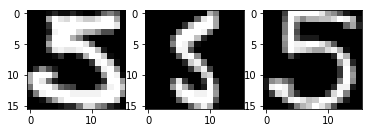

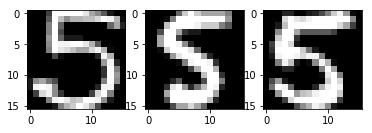

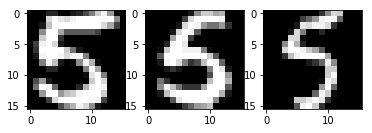

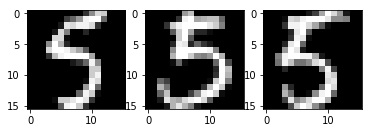

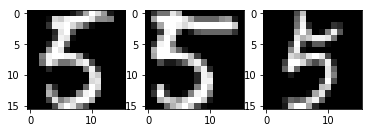

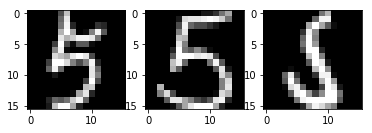

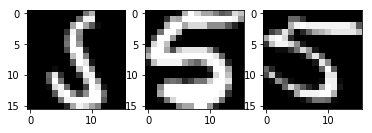

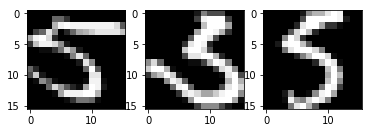

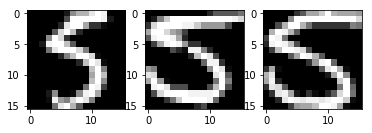

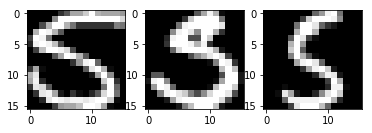

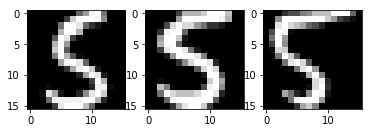

In [11]:
# print the digits 5 and 3, as they seem to be
# the most difficult digits to predict. We observe 
# that in many cases they are very badly written.
to_image(5, dict_train)

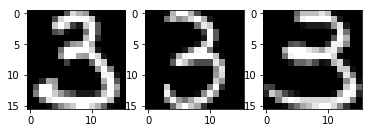

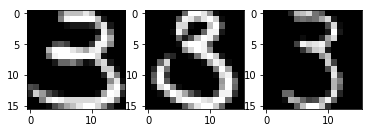

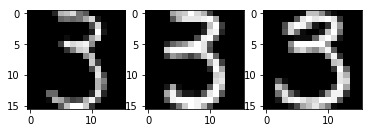

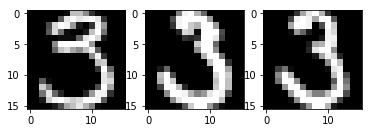

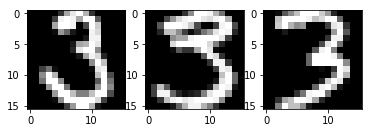

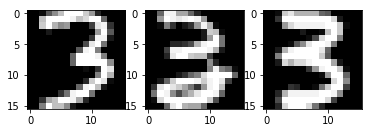

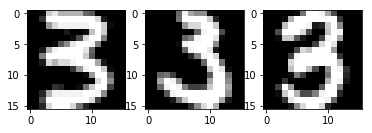

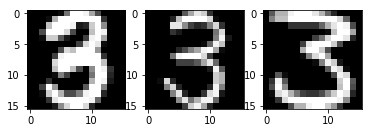

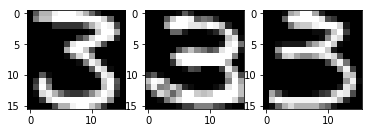

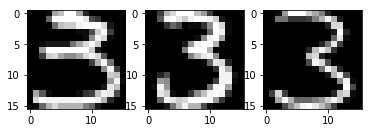

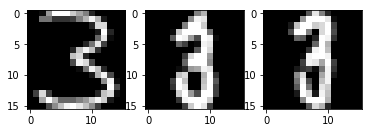

In [12]:
to_image(3, dict_train)

## Question 3

In [34]:
# Check the singular values of the different classes.
# In the class "1", we observe that first singular value
# is significantly higher than the rest singular values.
# Consequently, we could use fewer basis vector for that class.
# It should also be noted that this is the class which
# present the highest F1-score
for i in range(0, 10):
    print(i, svd_tranform(10, dict_train[i])[1])
    print()


0 [ 184.39208735   97.62999506   62.05144838   54.16719526   41.07251572
   40.3698978    36.29211339   30.04224049   29.02681274   24.95262983]

1 [ 234.04118961   41.93090664   24.84924907   16.29486533   13.61098805
   12.52206052   11.22864999   10.66852978    8.41487974    8.32324732]

2 [ 138.11303655   57.42205249   46.41253545   40.99243114   37.52899434
   33.54935583   32.261084     28.40927497   27.12355484   26.75231719]

3 [ 126.61913625   39.77346548   33.32515946   29.87409622   27.96518444
   24.77196174   24.38712751   21.46262269   19.06415242   18.59590136]

4 [ 123.00299503   41.62497098   34.93229398   32.29168628   26.81484224
   24.57001768   21.86946872   20.45010894   20.09385652   18.45663152]

5 [ 94.20966922  37.85636334  35.79668798  28.02520801  24.05115798
  22.47152231  20.63420827  20.37863014  17.08367974  16.83374893]

6 [ 141.95380469   52.19540036   37.96629568   32.01502395   26.28661476
   25.1406327    21.20116338   20.93586868   19.34309253   18

#### Use one basis vector in class 1 

In [43]:
y_pred = svd_classifier_adj(X_test, 15, svd_dict, 1)
print("Classification report for %s:\n%s\n"
      % ("SVD basis classification algorithm",
         classification_report(y_test, y_pred)))


Classification report for SVD basis classification algorithm:
             precision    recall  f1-score   support

          0       0.94      0.99      0.96       359
          1       1.00      0.84      0.91       264
          2       0.95      0.90      0.93       198
          3       0.90      0.89      0.90       166
          4       0.85      0.93      0.89       200
          5       0.91      0.88      0.90       160
          6       0.93      0.95      0.94       170
          7       0.93      0.96      0.95       147
          8       0.87      0.92      0.90       166
          9       0.93      0.95      0.94       177

avg / total       0.93      0.92      0.92      2007




In [44]:
digits = sorted(set(list(y_test.ravel())))
confusion = confusion_matrix(y_test, y_pred, labels=digits)
print(confusion)


[[355   0   2   0   1   0   0   0   0   1]
 [  0 221   1   0  18   0   9   0  15   0]
 [  9   0 179   3   3   1   0   1   2   0]
 [  3   0   3 148   1   8   0   1   2   0]
 [  1   1   0   0 186   1   3   3   0   5]
 [  4   0   2   9   0 141   0   0   1   3]
 [  3   0   0   0   3   2 162   0   0   0]
 [  0   0   1   0   3   0   0 141   0   2]
 [  3   0   1   4   0   2   0   1 153   2]
 [  0   0   0   0   3   0   0   4   2 168]]


#### Use two basis vectors in class 1

In [45]:
y_pred = svd_classifier_adj(X_test, 15, svd_dict, 2)
print("Classification report for %s:\n%s\n"
      % ("SVD basis classification algorithm",
         classification_report(y_test, y_pred)))


Classification report for SVD basis classification algorithm:
             precision    recall  f1-score   support

          0       0.94      0.99      0.96       359
          1       1.00      0.91      0.95       264
          2       0.95      0.90      0.93       198
          3       0.90      0.89      0.90       166
          4       0.88      0.93      0.90       200
          5       0.91      0.88      0.90       160
          6       0.93      0.95      0.94       170
          7       0.93      0.96      0.95       147
          8       0.94      0.92      0.93       166
          9       0.93      0.95      0.94       177

avg / total       0.93      0.93      0.93      2007




In [46]:
digit s= sorted(set(list(y_test.ravel())))
confusion = confusion_matrix(y_test, y_pred, labels=digits)
print(confusion)


[[355   0   2   0   1   0   0   0   0   1]
 [  0 239   1   0  12   0   9   0   3   0]
 [  9   0 179   3   3   1   0   1   2   0]
 [  3   0   3 148   1   8   0   1   2   0]
 [  1   1   0   0 186   1   3   3   0   5]
 [  4   0   2   9   0 141   0   0   1   3]
 [  3   0   0   0   3   2 162   0   0   0]
 [  0   0   1   0   3   0   0 141   0   2]
 [  3   0   1   4   0   2   0   1 153   2]
 [  0   0   0   0   3   0   0   4   2 168]]


#### Use three basis vectors in class 1

In [47]:
y_pred = svd_classifier_adj(X_test, 15, svd_dict, 3)
print("Classification report for %s:\n%s\n"
      % ("SVD basis classification algorithm",
         classification_report(y_test, y_pred)))


Classification report for SVD basis classification algorithm:
             precision    recall  f1-score   support

          0       0.94      0.99      0.96       359
          1       1.00      0.92      0.96       264
          2       0.95      0.90      0.93       198
          3       0.90      0.89      0.90       166
          4       0.88      0.93      0.91       200
          5       0.91      0.88      0.90       160
          6       0.94      0.95      0.95       170
          7       0.93      0.96      0.95       147
          8       0.95      0.92      0.94       166
          9       0.93      0.95      0.94       177

avg / total       0.94      0.94      0.94      2007




In [48]:
digits = sorted(set(list(y_test.ravel())))
confusion = confusion_matrix(y_test, y_pred, labels=digits)
print(confusion)


[[355   0   2   0   1   0   0   0   0   1]
 [  0 244   1   0  11   0   7   0   1   0]
 [  9   0 179   3   3   1   0   1   2   0]
 [  3   0   3 148   1   8   0   1   2   0]
 [  1   1   0   0 186   1   3   3   0   5]
 [  4   0   2   9   0 141   0   0   1   3]
 [  3   0   0   0   3   2 162   0   0   0]
 [  0   0   1   0   3   0   0 141   0   2]
 [  3   0   1   4   0   2   0   1 153   2]
 [  0   0   0   0   3   0   0   4   2 168]]


#### Use four basis vectors in class 1

In [49]:
y_pred = svd_classifier_adj(X_test, 15, svd_dict, 4)
print("Classification report for %s:\n%s\n"
      % ("SVD basis classification algorithm",
         classification_report(y_test, y_pred)))


Classification report for SVD basis classification algorithm:
             precision    recall  f1-score   support

          0       0.94      0.99      0.96       359
          1       1.00      0.93      0.96       264
          2       0.95      0.90      0.93       198
          3       0.90      0.89      0.90       166
          4       0.89      0.93      0.91       200
          5       0.91      0.88      0.90       160
          6       0.95      0.95      0.95       170
          7       0.93      0.96      0.95       147
          8       0.95      0.92      0.94       166
          9       0.93      0.95      0.94       177

avg / total       0.94      0.94      0.94      2007




In [50]:
digits = sorted(set(list(y_test.ravel())))
confusion = confusion_matrix(y_test, y_pred, labels=digits)
print(confusion)


[[355   0   2   0   1   0   0   0   0   1]
 [  0 246   1   0  10   0   6   0   1   0]
 [  9   0 179   3   3   1   0   1   2   0]
 [  3   0   3 148   1   8   0   1   2   0]
 [  1   1   0   0 186   1   3   3   0   5]
 [  4   0   2   9   0 141   0   0   1   3]
 [  3   0   0   0   3   2 162   0   0   0]
 [  0   0   1   0   3   0   0 141   0   2]
 [  3   0   1   4   0   2   0   1 153   2]
 [  0   0   0   0   3   0   0   4   2 168]]


Consequently, according to the above experiments it seems that it pays off to use fewer basis vectors in one some of the classes. Indeed, having more parsimonious models enables us to ensure avoiding also problems such as overfitting.

## Optional Question 1

In [51]:
# The second stage is unnecessary 1028 times.
# we observe that in the first stage of the algorithm
# are ussually classified digits of class 0,1 and 6. Indeed,
# those are the classes with the highest F1-score and accuracy
# as we observed also above.
y_pred = svd_classifier_adj2(X_test, 15, svd_dict)


The second stage is unnecessary 1028 times.
{0: 220, 1: 255, 2: 60, 3: 79, 4: 68, 5: 23, 6: 107, 7: 81, 8: 55, 9: 80}


According to the following classification report and confusion matrix it seems that it is possible to get as good results for this variant of the algorithm. Additionally, that version of the algorithm can be a little bit faster as we only compute the relative residual taking into account the first singular vector.

In [54]:
print("Classification report for %s:\n%s\n"
      % ("SVD basis classification algorithm",
         classification_report(y_test, y_pred)))


Classification report for SVD basis classification algorithm:
             precision    recall  f1-score   support

          0       0.94      0.98      0.96       359
          1       0.97      0.98      0.98       264
          2       0.95      0.89      0.92       198
          3       0.90      0.89      0.90       166
          4       0.90      0.93      0.91       200
          5       0.91      0.87      0.89       160
          6       0.96      0.95      0.96       170
          7       0.94      0.96      0.95       147
          8       0.95      0.92      0.94       166
          9       0.92      0.93      0.92       177

avg / total       0.94      0.94      0.94      2007




In [59]:
digits = sorted(set(list(y_test.ravel())))
confusion = confusion_matrix(y_test, y_pred, labels=digits)
print(confusion)


[[355   0   2   0   1   0   0   0   0   1]
 [  0 260   0   0   3   0   1   0   0   0]
 [  9   1 179   3   2   1   0   1   2   0]
 [  3   0   3 148   1   8   0   1   2   0]
 [  1   1   0   0 186   1   3   3   0   5]
 [  4   1   2   9   0 140   0   0   1   3]
 [  3   1   0   0   3   1 162   0   0   0]
 [  0   1   1   0   3   0   0 141   0   1]
 [  3   0   1   4   0   2   0   1 153   2]
 [  0   3   0   0   3   0   0   4   2 165]]
